<h1 style='color: brown; text-align:center;'>
    Подготовка данных и обучение нейронной сети для распознавания CAPTCHA
</h1>

In [23]:
import numpy as np
import time
import sys
sys.path.append('./../')

from cap_solver.image.img import Img
from cap_solver.image.imgs import Imgs
from cap_solver.image.utils import thinning
from cap_solver.neural_network.layer_fc import LayerFC
from cap_solver.neural_network.neural_network import NeuralNetwork, nn_load

Total time   (sec.):    0.1
Time per img (sec.):    0.0016
Total number of img:        39


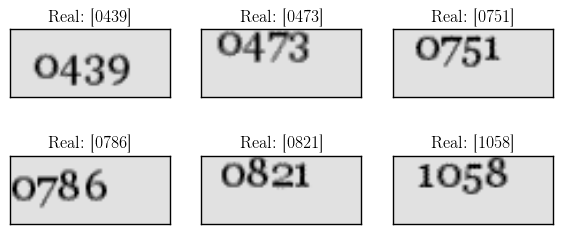

In [2]:
def fsmb2vec(s):
    v = np.zeros((10, 1)); v[int(s)] = 1.; return v

Ims0 = Imgs(fsmb2vec=fsmb2vec, verb=True)
Ims0.load('./data/cap')
Ims0.show(n=6, c=3, figsize=(7, 3), figsize_sub=(2, 2))

<h5 style='color: green; text-align:center;'>
    Анализ изображений (на примере первого изображения в базе)
</h5>

C:225->  1775      | C: 96->    64      | C:139->    59      | C:182->    51      | C: 53->    46      |
C:  0->    33      | C:189->    15      | C:219->    10      | C:224->     7      | C:132->     4      |
C: 16->     4      | C:175->     4      | C: 46->     3      | C: 90->     3      | C: 17->     3      |
C:133->     2      | C:145->     2      | C:218->     2      | C: 95->     2      | C: 60->     2      |
C:138->     1      | C:146->     1      | C: 47->     1      | C: 52->     1      | C:183->     1      |
C:188->     1      | C: 11->     1      | C: 97->     1      | C:102->     1      | Color: 225 | Count: 1775


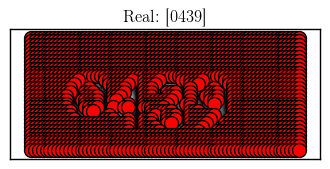

Color: 96  | Count: 64


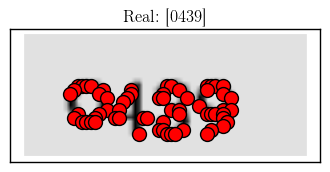

In [3]:
hist = Ims0[0].calc_hist(present=True)
for h in hist[:2]:
    print 'Color: %-3d | Count: %-d'%tuple(h)
    Ims0[0].show_colors(colors=h, figsize=(4, 4))

<h5 style='color: green; text-align:center;'>
    Бинаризация изображений
</h5>

Total time   (sec.):    0.1
Time per img (sec.):    0.0021


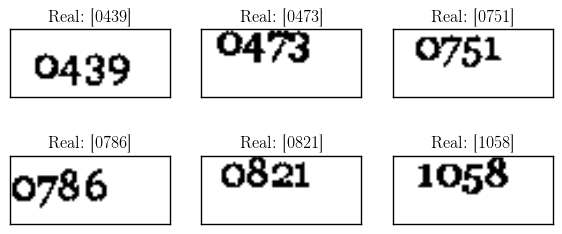

In [4]:
_t = time.time()
for Im in Ims0:
    Im.binarization(colors_bg=[225, 182, 189, 218, 175, 219, 224, 133, 138, 188])
print 'Total time   (sec.): %6.1f'%(time.time() - _t)
print 'Time per img (sec.): %9.4f'%((time.time() - _t)/Ims0.len_)
Ims0.show(n=6, r=2, figsize=(7, 3), figsize_sub=(2, 2))

<h5 style='color: green; text-align:center;'>
    Скелетизация (утоньшение) изображений
</h5>

Prepared:       39 /       39 | T_loop=0.0022  s., T_full=0.7     s., T_rem=0.0     s.
Total time   (sec.):    0.7
Time per img (sec.):    0.0188


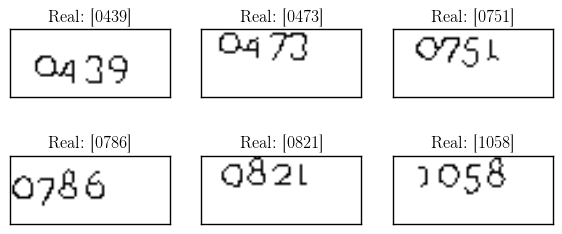

In [5]:
Ims0.apply(thinning, use_arr=True)
Ims0.show(n=6, r=2, figsize=(7, 3), figsize_sub=(2, 2))

<h5 style='color: green; text-align:center;'>
    Сегментация отдельных CAPTCHA с использованием простого порога по горизонтальной и вертикальной гистограммам (демонстрация) на отдельной CAPTCHA
</h5>

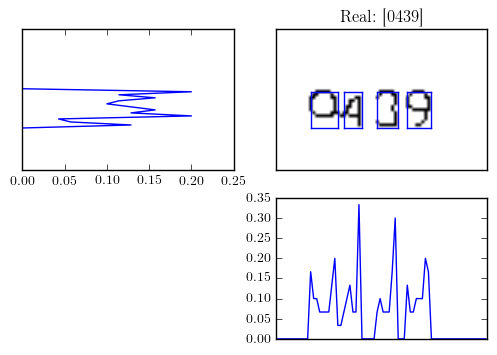

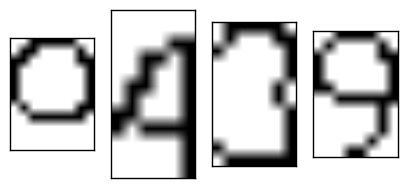

In [6]:
Ims_segm = Ims0[0].segmentation(thr_h=0., thr_w=0.05, show=True)
Ims_segm.show(n=4, r=1, figsize=(5, 5), figsize_sub=(2, 2))

<h5 style='color: green; text-align:center;'>
    Сегментация всех CAPTCHA с использованием простого порога по горизонтальной и вертикальной гистограммам, а также обрезка полученных изображений
</h5>

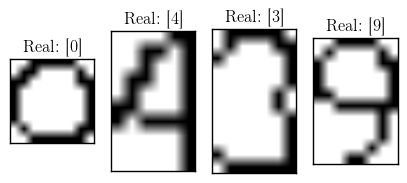

Процент ошибок сегментации: 15  
Размер полученной базы символов: 132
Максимальная высота изображения: 14 px
Максимальная ширина изображения: 9 px


In [7]:
Ims = Imgs(fsmb2vec=fsmb2vec, verb=True)
errors = 0
for Im in Ims0:
    Ims_segm = Im.segmentation(thr_h=0., thr_w=0.035, show=False, smbs_real=[int(s) for s in Im.smb_real])
    n = len(Ims_segm)
    if n != 4:
        errors+= 1
        #print 'Warning: incorrect segmentation result: only %d symbols are found.'%n
        continue
    for Im in Ims_segm:
        Im.crop()
    Ims.extend(Ims_segm)
H = max(Im.H for Im in Ims)
W = max(Im.W for Im in Ims)
Ims.show(n=4, r=1, figsize=(5, 5), figsize_sub=(2, 2))
print u'Процент ошибок сегментации: %-4.2d'%(errors*100./len(Ims0))
print u'Размер полученной базы символов: %d'%len(Ims)
print u'Максимальная высота изображения: %d px'%H
print u'Максимальная ширина изображения: %d px'%W

<h5 style='color: green; text-align:center;'>
    Дополняем все символы фоновой полосой справа и сверху для единообразия размеров
</h5>

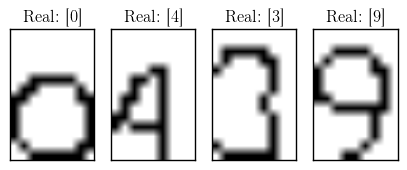

In [8]:
for Im in Ims:
    Im.resize(H, W)
Ims.show(n=4, r=1, figsize=(5, 5), figsize_sub=(2, 2))

<h5 style='color: green; text-align:center;'>
    Подготовка данных для обучения сети
</h5>
<ul>
    <li>
        Инициализация класса, представляющего данные
    </li>
    <li>
        Преобразование подготовленных изображений в матрицу входных и выходных векторов
    </li>
    <li>
        Разделение изображений на набор обучающих данных (100), валидационных данных (0) и тестовых данных (50)
    </li>
</ul>

In [9]:
_t = time.time()
X_all = Ims.get_matrix(var='arr')
Y_all = Ims.get_matrix(var='smb_real')
print X_all.shape
print Y_all.shape
N_trn = 10
X_trn, Y_trn = X_all[:, :N_trn], Y_all[:, :N_trn]
X_tst, Y_tst = X_all[:, N_trn:], Y_all[:, N_trn:]
print 'Total time   (sec.): %6.1f'%(time.time() - _t)
print 'Time per img (sec.): %9.4f'%((time.time() - _t)/Ims.len_)

(126, 132)
(10, 132)
Total time   (sec.):    0.0
Time per img (sec.):    0.0000


<h5 style='color: green; text-align:center;'>
    Создание нейронной сети
</h5>
<ul>
    <li>
        Инициализируется экземпляр класса нейронной сети и выставляется опция печати промежуточной информации
    </li>
    <li>
        Создаются три слоя с числами нейронов 784 (входной слой), 30 (внутренний слой), 10 (выходной слой)
    </li>
    <li>
        Гиперпараметр числа элементов в подвыборке выбран равным 10, а гиперпараметр скорости обучения выбран равным 3 (на основе ряда текстых расчетов по выбору оптимального значения гиперпараметров)
    </li>
</ul>

In [17]:
NN = NeuralNetwork(verb=True)
NN.add_layers(LayerFC(H*W ,  50))
NN.add_layers(LayerFC(50  ,  50))
NN.add_layers(LayerFC(50  ,  50))
NN.add_layers(LayerFC(50  ,  10))
NN.add_layers(LayerFC( 10 ,  10))
NN.set_params(mb_size=2, eta=0.2)

<h5 style='color: green; text-align:center;'>
    Обучение нейронной сети
</h5>
<ul>
    <li>
        Выбрано 30 эпох для обучения
    </li>
    <li>
        Выходная информация на каждой эпохе обучения:
    </li>
    <ul>
        <li>
            Номер эпохи
        </li>
        <li>
            Время в секундах, затраченное на эпоху
        </li>
        <li>
            Полное количество итераций обратного распространения в сети (с момента создания сети) 
        </li>
        <li>
            Количество данных в тестовом наборе
        </li>
        <li>
            Качество сети после соотвествующей эпохи обучения на тестовом наборе данных (относительная доля неправильных результатов предсказания)
        </li>
    </ul>
</ul>

In [18]:
NN.learning(X_trn, Y_trn, X_tst, Y_tst, epochs=200)

Epoch #  1: T=    0.01; m=       10; n_check=      122; e_check=0.909836
Epoch #  2: T=    0.01; m=       20; n_check=      122; e_check=0.934426
Epoch #  3: T=    0.01; m=       30; n_check=      122; e_check=0.934426
Epoch #  4: T=    0.01; m=       40; n_check=      122; e_check=0.934426
Epoch #  5: T=    0.01; m=       50; n_check=      122; e_check=0.934426
Epoch #  6: T=    0.01; m=       60; n_check=      122; e_check=0.934426
Epoch #  7: T=    0.01; m=       70; n_check=      122; e_check=0.934426
Epoch #  8: T=    0.01; m=       80; n_check=      122; e_check=0.934426
Epoch #  9: T=    0.01; m=       90; n_check=      122; e_check=0.934426
Epoch # 10: T=    0.01; m=      100; n_check=      122; e_check=0.934426
Epoch # 11: T=    0.01; m=      110; n_check=      122; e_check=0.934426
Epoch # 12: T=    0.01; m=      120; n_check=      122; e_check=0.934426
Epoch # 13: T=    0.01; m=      130; n_check=      122; e_check=0.934426
Epoch # 14: T=    0.01; m=      140; n_check=      

<i>Комментарий:</i> как следует из результатов, нейронная сеть после 30 эпох обучения дает всего лишь
$0.053800 \times 10000 = 538$
ошибок на тестовой выборке размера 10000 (качество предсказания может быть существенно улучшено путем лучшего выбора гиперпараметров сети).

<h5 style='color: green; text-align:center;'>
    Проверка качества предсказания на конкретном примере
</h5>
<ul>
    <li>
        Выбираем одно изображение (последнее изображение из набора) для примера и получаем соответствующие интенсивности пикселей (x)
    </li>
    <li>
        Запускаем расчет посредством обученной нейронной сети и выводим результат (предсказание сети)
    </li>
    <li>
        Отрисовываем изображение
    </li>
</ul>

The answer of the neural network is  9


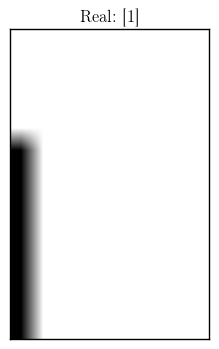

In [25]:
Im = Ims[-1]
x = Im.get_vector('arr')
a = NN.forward(x)
print 'The answer of the neural network is ', np.argmax(a)
Im.show(figsize=(4, 4))

<h5 style='color: green; text-align:center;'>
    Сохраняем обученную нейронную сеть в файл для возможности последующего использования
</h5>

In [20]:
NN.save('./nn_cap.p')

<h5 style='color: green; text-align:center;'>
    Загружаем (для проверки корректности опции сохранения) обученную нейронную сеть из файла
</h5>

In [24]:
NN = nn_load('./nn_cap.p')